# H-1B Visa Approvals  (2011-2017): Part 1


## Preprocessing and Wrangling
  
  
**AMOD-5410H: Big Data**   
**Winter 2018**  
**Nicholas Hopewell - 0496633**

**Overview:**
The original source of these data comes from the US department of labour. H-1B visas are a category of employment-based, non-immigrant visas for temporary foreign workers in the United States. For a foreign national to apply for H1-B visa, a US employer must offer them a job and submit a petition for a H-1B visa to the US immigration department. This is also the most common visa status applied for and held by international students once they complete college or higher education and begin working in a full-time position.

**Data:**
This dataset contains seven year's worth of H-1B petition data, with a little over 3.6 million records in total. The columns in the final dataset (after preprocessing and explpratory analysis) include case status, employer name, worksite coordinates, job title, prevailing wage, occupation code, and year filed.

**Note:** The fully cleaned and combined version of these data appeared partially on Kaggle.com: https://www.kaggle.com/nsharan/h-1b-visa  

For the Kaggle data, the data wrangling and cleaning was done with R (mostly with dplyr) - this process will be replicated here with Python (see below): 

**The current work:** I will not use the cleaned and combined data but instead begin with the raw separate data files and do my own cleaning, wrangling, and analysis of the data with Python. I will also be using more recently available data in addition to that included on kaggle. My goal is to arrive at the same cleaned state as the data used on Kaggle by using Python and Pandas/Numpy for cleaning and wrangling instead of R and dplyr. I will also replicate some of this process with pyspark as well. 

It should also be noted that I greatly improved the data wrangling process compared to the original process done in R. 

The supervised learning stage will also be done with both python ml libraries (scikit) and spark ml libraries (mllib). I may also do this phase with R and Caret as well as with sparklyr. The R component would not be included in this notebook but instead in an Rmarkdown file.

In [1]:
import pandas as pd
import numpy as np
# to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format
# filte out package warnings
import warnings
warnings.filterwarnings('ignore')

The data come from seven separate .csv files. First, I need to create a main data frame as an empty frame which I will concatenate the data from each excel file to.

In [2]:
#empty dframe to populate
main_frame = pd.DataFrame()

Now I can read in each of the data files. Data before 2015 had slightly different variable names but the same information. These columns will be renamed to match the new variable names. Some of the unnecessary columns will also be filtered out of the data.

In [3]:
# for each year, year is injected into the f-string and the apporpriate file is read.
# file_path is created as a 1-dimensional list - if it were not within the forloop, list comprehension would
# include an imbedded for

for year in range(2011, 2018):
    print(f"***Reading {year} data files...")
    file_path = [f"C:/Users/nicho/Desktop/big data course proj/H-1B data/H-1B_{year}.xlsx"]
    my_df = pd.read_excel(file_path[0])
    
    # rename old columns to match
    if year < 2015:
        print("Renaming old columns...")
        my_df.rename(columns={'LCA_CASE_NUMBER' : 'CASE_NUMBER', 
                             'STATUS' : 'CASE_STATUS',
                             'LCA_CASE_EMPLOYER_NAME' : 'EMPLOYER_NAME', 
                             'LCA_CASE_SOC_NAME' : 'SOC_NAME',
                             'LCA_CASE_SOC_CODE' : 'SOC_CODE', 
                             'LCA_CASE_JOB_TITLE' : 'JOB_TITLE',
                             'FULL_TIME_POS' : 'FULL_TIME_POSITION', 
                             'PW_1' : 'PREVAILING_WAGE', 
                             'PW_UNIT_1' : 'PW_UNIT_OF_PAY',
                             'LCA_CASE_WORKLOC1_CITY' : 'WORKSITE_CITY',
                             'LCA_CASE_WORKLOC1_STATE' : 'WORKSITE_STATE'}, inplace=True)
    
    # add year
    print("Adding year column...")
    my_df['YEAR'] = str(year)
    
    print(f"Dimension of data frame: {my_df.shape}")
    
    # select appropriate columns
    print("Selecting required columns...")
    my_df = my_df[['CASE_NUMBER',
                    'CASE_STATUS',
                    'EMPLOYER_NAME',
                    'SOC_NAME',
                    'SOC_CODE',
                    'JOB_TITLE',
                    'FULL_TIME_POSITION',
                    'PREVAILING_WAGE',
                    'PW_UNIT_OF_PAY',
                    'WORKSITE_CITY',
                    'WORKSITE_STATE',
                    'YEAR']]
    
    # merge data into main dframe
    print("Joining data onto main frame...")
    main_frame = pd.concat([main_frame, my_df])
    
    print(f"Dimension of main data frame: {main_frame.shape}\n")
         

***Reading 2011 data files...
Renaming old columns...
Adding year column...
Dimension of data frame: (358857, 36)
Selecting required columns...
Joining data onto main frame...
Dimension of main data frame: (358857, 12)

***Reading 2012 data files...
Renaming old columns...
Adding year column...
Dimension of data frame: (415845, 36)
Selecting required columns...
Joining data onto main frame...
Dimension of main data frame: (774702, 12)

***Reading 2013 data files...
Renaming old columns...
Adding year column...
Dimension of data frame: (442275, 36)
Selecting required columns...
Joining data onto main frame...
Dimension of main data frame: (1216977, 12)

***Reading 2014 data files...
Renaming old columns...
Adding year column...
Dimension of data frame: (519504, 36)
Selecting required columns...
Joining data onto main frame...
Dimension of main data frame: (1736481, 12)

***Reading 2015 data files...
Adding year column...
Dimension of data frame: (618804, 41)
Selecting required columns..

3,627,787 rows x 12 columns.

### Data Dictionary

Only including the attributes used. Complete dictionary can be found at: https://www.foreignlaborcert.doleta.gov/docs/Performance_Data/Disclosure/FY15-FY16/H-1B_FY16_Record_Layout.pdf 

* **CASE_NUMBER:** Unique identifier assigned to each application submitted for processing to the Chicago National Processing Center.
* **CASE_STATUS:** Status associated with the last significant event or decision. Valid values include "Certified," "Certified-Withdrawn," Denied," and "Withdrawn."  
* **EMPLOYER_NAME:** Name of employer submitting labor condition application.
* **SOC_NAME:** Occupational name associated with the SOC_CODE.
* **SOC_CODE:** Occupational code associated with the job being requested for temporary labor condition, as classified by the Standard Occupational Classification (SOC) System. 
* **JOB_TITLE:** Title of the job.  
* **FULL_TIME_POSITION:** Y = Full Time Position; N = Part Time Position. 
* **PREVAILING_WAGE:** Prevailing Wage for the job being requested for temporary labor condition.  
* **PW_UNIT_OF_PAY:** Unit of Pay. Valid values include "Daily (DAI)," "Hourly (HR)," "Bi-weekly (BI)," "Weekly (WK)," "Monthly (MTH)," and "Yearly (YR)."
* **WORKSITE_CITY:** City information of the foreign worker's intended area of employment. 
* **WORKSITE_STATE:** State information of the foreign worker's intended area of employment. 
* **YEAR:** Year petition was filed. 


Here is what a portion of the data looks like. Notice the 'YEAR' column. As the separate data files have been concatenated by rows, the oldest data (from 2011) appears first.

In [4]:
main_frame.head(5)

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
0,I-200-09124-371007,CERTIFIED,WILLISTON NORTHAMPTON SCHOOL,"Teachers and Instructors, All Other*",25-3999,CHINESE TEACHER,Y,23350,Year,EASTHAMPTON,MA,2011
1,I-200-09125-717448,CERTIFIED,"NYFIX, INC.","Computer Software Engineers, Applications",15-1031.00,PROJECT MANAGER,Y,101088,Year,NEW YORK,NY,2011
2,I-200-09126-530125,CERTIFIED-WITHDRAWN,TGS-NOPEC GEOPHYSICAL COMPANY,"Computer Software Engineers, Applications",15-1031.00,PRINCIPAL TRAINER / DEVELOPMENT ANALYST,Y,77480,Year,HOUSTON,TX,2011
3,I-200-09127-370154,CERTIFIED,"AFREN USA, INC.",Engineering Managers,11-9041.00,DRILLING MANAGER,Y,165506,Year,THE WOODLANDS,TX,2011
4,I-200-09127-334015,CERTIFIED,"BA-INSIGHT, LLC",Computer Support Specialists,15-1041.00,TECHNICAL SUPPORT ENGINEER,Y,62358,Year,BOSTON,MA,2011


The most recent data from 2017...

In [5]:
main_frame.tail(5)

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
624645,I-200-16188-449352,CERTIFIED-WITHDRAWN,FAST SWITCH LTD,"SOFTWARE DEVELOPERS, APPLICATIONS",15-1132,SENIOR JAVA DEVELOPER,Y,37.12,Hour,DUBLIN,OH,2017
624646,I-200-16309-239165,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,PHYSICISTS,19-2012,POSTDOCTORAL ASSOCIATE,Y,50398.00,Year,CAMBRIDGE,MA,2017
624647,I-200-16363-692687,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,"GEOSCIENTISTS, EXCEPT HYDROLOGISTS AND GEOGRAP...",19-2042,RESEARCH SCIENTIST,Y,61069.00,Year,CAMBRIDGE,MA,2017
624648,I-200-17055-511599,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,MATERIALS ENGINEERS,17-2131,POSTDOCTORAL ASSOCIATE,Y,41392.00,Year,CAMBRIDGE,MA,2017
624649,I-200-17068-828736,CERTIFIED,"PARK VIEW TRAVEL BEVERLY HILLS, LLC","MEETING, CONVENTION, AND EVENT PLANNERS",13-1121,EVENTS AND INCENTIVES COORDINATOR,Y,45198.00,Year,BEVERLY HILLS,CA,2017


I will save this data file as a master file before making a copy of it for analysis.

In [6]:
# write to csv
main_frame.to_csv("./Desktop/big data course proj/H-1B data/complete_data_v1.csv", index = False)

In [7]:
# make a copy of the dframe
h1b_data = main_frame
# confirm copy
h1b_data.shape

(3627787, 12)

In [8]:
# verify pd df:
type(h1b_data)

pandas.core.frame.DataFrame

Working with the copied data, it is important to see whether python has classified the data types appropriately:

In [9]:
h1b_data.dtypes

CASE_NUMBER           object
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
SOC_CODE              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       object
PW_UNIT_OF_PAY        object
WORKSITE_CITY         object
WORKSITE_STATE        object
YEAR                  object
dtype: object

Notice every variable is classified as an object. The native python type equivalent to a pandas object type is a string. The object pandas data type is the most generic data type and is assigned to any column which contains multiple data type or if the data types could not be classified correctly (common with larger amounts of data). If this becomes a problem they should be explicitly changed. Wage is really the only one which should be changed.

For each column, how many rows contain missing data:

In [10]:
h1b_data.isnull().sum()

CASE_NUMBER                0
CASE_STATUS                0
EMPLOYER_NAME            417
SOC_NAME               18023
SOC_CODE                 511
JOB_TITLE                328
FULL_TIME_POSITION    648166
PREVAILING_WAGE          666
PW_UNIT_OF_PAY           738
WORKSITE_CITY            529
WORKSITE_STATE           474
YEAR                       0
dtype: int64

A significant number of records do not contain information on whether the position was full time ('Y') or not ('N'). Just under 18% of the data.  

In [11]:
# proportion with missing position data
h1b_data['FULL_TIME_POSITION'].isnull().sum() / len(h1b_data.index)

0.17866704963659663

### Comparing wages


Upon researching issues with prevailing wage calculations, americanimmigrationcouncil.org stated there are a few issues: 

> "Calculating the prevailing wage in an occupation is critical to ensuring that foreign-born workers do not get paid more than native-born workers (or vice versa) for performing comparable tasks. Pay inequity could give an unfair advantage to one group of workers over another. It is for that reason that the prevailing wage determination is such an important aspect of the employment-based immigration system.

> However, there are three sets of problems surrounding the way in which a current Prevailing Wage Determination is issued in our high-skilled immigration system: (1) the underlying data is based on very broad pay ranges; (2) there are intrinsic weaknesses in issuing prevailing wage determinations for specific positions offered by an individual employer based on generalized occupational employment statistics; and (3) the current system does not reflect education, experience, and supervision."


To make sure these calculations were done and entered validly, it is important to explore the prevailing wage data. Inspecting wages, pay was not recorded in the same time intervals across the board. To make comparisons, this scale must be of equal time intervals for all records.  

Here are the counts for the different units of pay used in the data set:

In [12]:
# group by unit of pay, summarize as count
units = h1b_data.groupby('PW_UNIT_OF_PAY').agg('count').iloc[:,1]
units

PW_UNIT_OF_PAY
Bi-Weekly        377
Hour          270919
Month           3708
Week            1756
Year         3350289
Name: CASE_STATUS, dtype: int64

In [13]:
# proportions
units/len(h1b_data.index)

PW_UNIT_OF_PAY
Bi-Weekly   0.00
Hour        0.07
Month       0.00
Week        0.00
Year        0.92
Name: CASE_STATUS, dtype: float64

The large majority of records are associated with a yearly unit of pay (> 92% ), a fair number include hourly unit of pay (> 7% ), while other units of pay are barely represented in the dataset. These units of pay can all easily be converted to match the yearly unit of pay to make all records consistent.

In [14]:
h1b_data.iloc[1,8] == 'Year'

True

In [15]:
# to convert units of pay
def pay_to_yearly(wage, unit):
    if unit == "Year":
        result = wage
    elif unit   == "Week":
        result = 52 * wage
    elif unit   == "Month":
        result = 12 * wage
    elif unit == "Hour":
        result = 2080 * wage
    else :
        result = 26 * wage
    return result
    

Attempting to convert the prevailing wage column to numeric yields an error. Row 455172 cannot be converted to type numeric.

In [16]:
h1b_data.iloc[455172, 7:9]

PREVAILING_WAGE    9.78
PW_UNIT_OF_PAY     Hour
Name: 96315, dtype: object

Now it is clear that this record contains a range of values separated by a hyphen. This individuals wage is \$20 to \$70 an hour. Not very helpful to us. How many records contain a similar issue?

In [17]:
sum(h1b_data.PREVAILING_WAGE.str.contains('-', na = False))

1

Thankfully, it seems that only the one record has this issue and can simply be removed. 

In [18]:
# drop record
h1b_data = h1b_data[~h1b_data.PREVAILING_WAGE.str.contains('-', na = False)]

Now wages can be converted and units of pay can be standardized to yearly pay for all records.

In [19]:
# drop missing data from col, transform to num + str
h1b_data = h1b_data.dropna(subset=['PW_UNIT_OF_PAY'])
h1b_data['PREVAILING_WAGE'] = h1b_data['PREVAILING_WAGE'].transform(pd.to_numeric)
h1b_data['PW_UNIT_OF_PAY'] = h1b_data['PW_UNIT_OF_PAY'].astype(str)

Before prevailing wage is altered, it is crucial to understand some basic information about the wages to ensure applying any function results in intended outcomes. Summary statistics: 

In [20]:
#summary statistics:
h1b_data['PREVAILING_WAGE'].describe()

count     3626977.00
mean        67774.66
std        782127.16
min             0.00
25%         52395.00
50%         64501.00
75%         81515.00
max     820132347.00
Name: PREVAILING_WAGE, dtype: float64

Something which immediately jumps out is the very high max value and seemingly also very high standard deviation for wages. This would imply that there are some huge outliers which are pulling the mean wage up and hugely inflating the standard deviation. The standard deviation is only slightly being impacted by the outliers, the huge SD mainly is a result of having prevailing wages in multiple units (some of which are orders of magnitude different). The mean here is also very misleading, in fact, it is artificially low due to the presence of some units of pay being sub $100. The max values are most interesting from these data.
  
The median prevailing wage will give a better idea of central tendency but will still be biased due to the presence of multiple scales:

In [21]:
h1b_data['PREVAILING_WAGE'].median()

64501.0

 Let's inspect the records with the highest wages to see if possible data entry errors have occurred:

In [22]:
h1b_data.nlargest(40, 'PREVAILING_WAGE')

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
407395,I-200-14163-698141,DENIED,DISCOVER PRODUCTS INC.,Statisticians,15-2041,PROJECT MANAGER,Y,820132347.00,Year,RIVERWOODS,IL,2014
33769,I-200-12314-455612,DENIED,"IDEXCEL, INC.","Software Developers, Applications",15-1132,.NET DEVELOPER,Y,709999949.00,Year,COLUMBUS,OH,2013
132271,I-200-11067-452033,DENIED,COMMONHEALTH ACTION,Medical and Health Services Managers,11-9111.00,PROGRAM MANAGER (POSITIVE PATHWAYS),Y,657900000.00,Year,WASHINGTON,NaN,2011
281084,I-200-14077-075359,DENIED,ARKRIT LLC,Computer Systems Analysts,15-1121,PROGRAMMER/ANALYST,Y,616931693.00,Year,SAN JOSE,CA,2014
401912,I-200-14160-081071,DENIED,HOWARD HUGHES MEDICAL INSTITUTE,"Life Scientists, All Other",19-1099,RESEARCH ASSOCIATE,Y,413472579.00,Year,ASHBURN,VA,2014
222828,I-200-17064-887537,DENIED,WIPRO LLC,"COMPUTER OCCUPATIONS, ALL OTHER",15-1199,CONSULTANT LEVEL 3,Y,201622735.00,Year,SUNNYVALE,CA,2017
188236,I-200-11108-332859,DENIED,XORIANT CORPORATION,"Computer Software Engineers, Systems Software",15-1032.00,COMPUTER SYSTEMS SOFTWARE ENGINEER,Y,77147000.00,Year,SUNNYVALE,CA,2011
93267,I-200-12005-031899,WITHDRAWN,"UNIVERSITY OF CALIFORNIA, BERKELEY",Biochemists and Biophysicists,19-1021,ASSISTANT PROJECT SCIENTIST,Y,52354498.00,Year,BERKELEY,CA,2012
327136,I-200-11236-463527,DENIED,"BYTEWARE, INC.",Computer Systems Analysts,15-1121,BUSINESS ANALYST,Y,35266600.00,Year,ST. LOUIS,MO,2011
317641,I-200-13141-752670,DENIED,"MARYLAND INPATIENT CARE SPECIALISTS, LLC","Internists, General",29-1063,HOSPITALIST,Y,15094600.00,Year,BALTIMORE,MD,2013


Notice that every one of the highest values are in yearly units. This does not confirm data entry errors were not committed but it does rule out any obvious errors (such as an individual making 45 million dollars an hour). 

Visualizing the distribution of wages:


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
# to remove plot.show requirement
%matplotlib inline

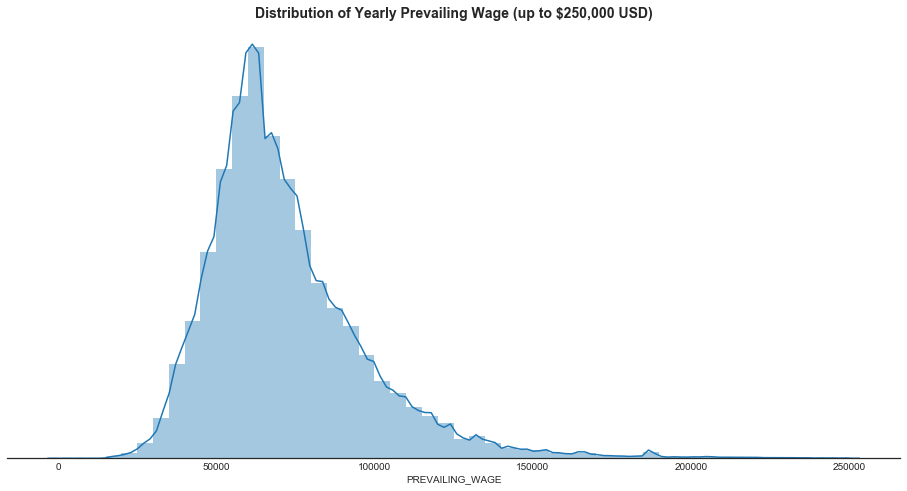

In [24]:
# create the matplotlib Figure and Axes objects
ax_dims = (16, 8)
fig, ax = plt.subplots(figsize=ax_dims)
#remove borders including left which is not needed to see shape of dist
sns.despine(left=True)
plt.yticks([]) # hide y ticks
# plot yearly prevailing wage (subset)
sns.distplot(h1b_data[(h1b_data['PW_UNIT_OF_PAY']  == 'Year') & 
                      (h1b_data['PREVAILING_WAGE'] <= 250000)]['PREVAILING_WAGE']).set_title(
                                'Distribution of Yearly Prevailing Wage (up to $250,000 USD)', weight='bold').set_fontsize('14')

As expected with most financial data (wages, house prices, etc.) the distribution is very positively skewed. Even subsetting the data down to a maximum yearly prevailing wage of $250000, the strong skew of the distribution is seen. I will not remove the very large positive outliers at this point, but I may later on. As the large majority of the data is in yearly units of pay and the records falling under the other units would be expected to show a similar distribution, they will not be plotted.

I can now apply the previously made function to standardize units of pay to all be in yearly units:

In [25]:
# apply function to wage
h1b_data['PREVAILING_WAGE'] = h1b_data[['PREVAILING_WAGE', 'PW_UNIT_OF_PAY']].apply(
    lambda x: pay_to_yearly(*x), axis = 1
)

# check it first:
#test = h1b_data[['PREVAILING_WAGE', 'PW_UNIT_OF_PAY']].apply(lambda x: pay_to_yearly(*x), axis = 1)

After standardizing, let's make sure the wages are all correct.

In [26]:
# confirm
h1b_data.tail(5)

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
624645,I-200-16188-449352,CERTIFIED-WITHDRAWN,FAST SWITCH LTD,"SOFTWARE DEVELOPERS, APPLICATIONS",15-1132,SENIOR JAVA DEVELOPER,Y,77209.60,Hour,DUBLIN,OH,2017
624646,I-200-16309-239165,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,PHYSICISTS,19-2012,POSTDOCTORAL ASSOCIATE,Y,50398.00,Year,CAMBRIDGE,MA,2017
624647,I-200-16363-692687,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,"GEOSCIENTISTS, EXCEPT HYDROLOGISTS AND GEOGRAP...",19-2042,RESEARCH SCIENTIST,Y,61069.00,Year,CAMBRIDGE,MA,2017
624648,I-200-17055-511599,CERTIFIED,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,MATERIALS ENGINEERS,17-2131,POSTDOCTORAL ASSOCIATE,Y,41392.00,Year,CAMBRIDGE,MA,2017
624649,I-200-17068-828736,CERTIFIED,"PARK VIEW TRAVEL BEVERLY HILLS, LLC","MEETING, CONVENTION, AND EVENT PLANNERS",13-1121,EVENTS AND INCENTIVES COORDINATOR,Y,45198.00,Year,BEVERLY HILLS,CA,2017


Notice the wage of the first record was originally in hours (with an hourly pay of \$37.12) and has been successfully converted to yearly. Also notice that the wages which were in yearly units remain unchanged. Now that units are all in yearly, the units column adds no information and can be dropped.

Density plot of the complete data set after the transformation to look for any issues: 

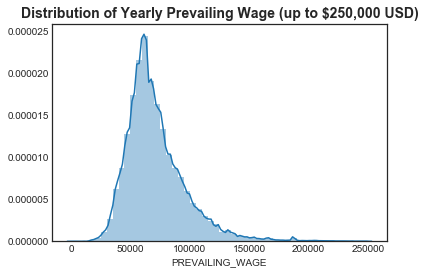

In [27]:
# entire data set
sns.distplot(h1b_data[h1b_data['PREVAILING_WAGE'] <= 250000]['PREVAILING_WAGE']).set_title(
                                 'Distribution of Yearly Prevailing Wage (up to $250,000 USD)', 
                                 weight='bold').set_fontsize('14')

It appears the transformation was successful, the distribution of the entire standardized data is identical to that of the yearly subsetted data. 

Now that the wages are standardized, descriptive statistics will be reflective of the data equally:

In [28]:
h1b_data['PREVAILING_WAGE'].describe()

count      3626977.00
mean        138840.36
std        4869080.00
min              0.00
25%          55162.00
50%          66206.00
75%          82888.00
max     6997606720.00
Name: PREVAILING_WAGE, dtype: float64

Looking closer at the error:

In [29]:
h1b_data.nlargest(10, 'PREVAILING_WAGE')

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
377434,I-200-13198-142691,DENIED,"GUARDIAN HEALTHCARE PROVIDERS, INC.",Physical Therapists,29-1123,PHYSICAL THERAPISTS,Y,6997606720.00,Hour,PEKIN,IL,2013
154357,I-200-11082-413524,DENIED,"SCIVANTAGE, INC.",Computer Programmers,15-1021.00,SOFTWARE DEVELOPER,Y,1007814080.00,Hour,JERSEY CITY,NJ,2011
407395,I-200-14163-698141,DENIED,DISCOVER PRODUCTS INC.,Statisticians,15-2041,PROJECT MANAGER,Y,820132347.00,Year,RIVERWOODS,IL,2014
33769,I-200-12314-455612,DENIED,"IDEXCEL, INC.","Software Developers, Applications",15-1132,.NET DEVELOPER,Y,709999949.00,Year,COLUMBUS,OH,2013
132271,I-200-11067-452033,DENIED,COMMONHEALTH ACTION,Medical and Health Services Managers,11-9111.00,PROGRAM MANAGER (POSITIVE PATHWAYS),Y,657900000.00,Year,WASHINGTON,NaN,2011
281084,I-200-14077-075359,DENIED,ARKRIT LLC,Computer Systems Analysts,15-1121,PROGRAMMER/ANALYST,Y,616931693.00,Year,SAN JOSE,CA,2014
401912,I-200-14160-081071,DENIED,HOWARD HUGHES MEDICAL INSTITUTE,"Life Scientists, All Other",19-1099,RESEARCH ASSOCIATE,Y,413472579.00,Year,ASHBURN,VA,2014
19923,I-200-12296-827859,DENIED,GOOGLE INC.,Architectural and Engineering Managers,11-9041,"MANAGER, SOFTWARE ENGINEERING",Y,410315360.00,Hour,MOUNTAIN VIEW,CA,2013
152446,I-200-11081-099118,WITHDRAWN,ICAP CORPORATES LLC,Financial Managers,11-3031.00,"MANAGING DIRECTOR, EQUITY DERIVATIVES",Y,406637920.00,Hour,JERSEY CITY,NJ,2011
596248,I-200-17239-563554,DENIED,"MGMC, LLC, A SUBSIDIARY OF MEDSTAR GEORGETOWN ...","INTERNISTS, GENERAL",29-1063,HOSPITALIST,Y,401360960.00,Hour,OLNEY,MD,2017


Most of the very high outliers (including the new maximum wage) are actually those whose prevailing wages were in hourly units. This has massively inflated the standard deviation. A sense of how powerful the positive skew in these data are can be found by comparing the max prevailing wage values to the 75% percentile. 75% of the wages fall below \$82888 while the highest wage values are many orders of magnitude greater. One can see that, after standardization, the 75th percentile remained mostly unchanged but the max value and SD were pulled way up due to the number of hourly outliers who were converted to yearly. 

Another keen observation is that the min value is \$0.0. It does not make sense to have a prevailing wage for a job requested to be $0. This is likely a placeholder for missing data but I do not believe it should be and is misleading and could inject error into a decision-making algorithm if not noticed. If the data are missing and simply replaced by 0.0, any model that requires no data to be missing will not complain about this scenario and will run as expected but the results will not be as accurate.  

The influence of this issue, and how much error it might inject into a model, depends on how represented the issue is in these data. 

In [30]:
sum(h1b_data['PREVAILING_WAGE'] == 0.0)

41

It looks like only 41 records were encoded in this way. This is good because now I can simply drop these values without having to sacrifice much useful training data and overall the model will not be worse off in any significant way (due to the shear size of this data set). 

In [31]:
# drop records with replaced vals
h1b_data = h1b_data.drop(h1b_data.index[h1b_data.PREVAILING_WAGE == 0.0])
sum(h1b_data['PREVAILING_WAGE'] == 0.0)

0

Now these values have been dropped from the data, let's look at the new minimum:

In [32]:
h1b_data['PREVAILING_WAGE'].min()

15.16

In yearly units, this value does not make sense. Let's look at the smallest values of these data:


In [33]:
h1b_data.nsmallest(10, 'PREVAILING_WAGE')

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,YEAR
30386,I-200-11298-492780,DENIED,FREEDOM GUITAR INC.,Sound Engineering Technicians,27-4014,SOUND ENGINEER,N,15.16,Year,SAN DIEGO,CA,2012
356204,I-200-17079-327361,DENIED,"KNOWBE4, INC.","SOFTWARE DEVELOPERS, APPLICATIONS",15-1132,SOFTWARE ENGINEER,Y,25.58,Year,CLEARWATER,FL,2017
382915,I-200-12228-770804,DENIED,KALVEN TECHNOLOGIES INC,"Software Developers, Applications",15-1132,SOFTWARE ENGINEER,N,31.69,Year,ELK GROVE VILLAGE,IL,2012
612589,I-200-16144-004009,DENIED,CENTRO CULTURAL ESPANOL INC,ART DIRECTORS,27-1011,CULTURAL DIRECTOR,NaN,35.00,Year,MIAMI,FL,2016
606179,I-201-15111-542646,DENIED,TEST,ADVERTISING SALES AGENTS,41-3011,ADSF,Y,52.00,Week,TEST,DE,2015
28588,I-200-10303-461255,DENIED,"ALTUS TECHNOLOGIES,INC",Computer Programmer Non R & D,15-1022.00,PROGRAMMER ANALYST,Y,63.45,Year,RALEIGH,NC,2011
313333,I-200-16035-732538,DENIED,GOR CORPORATION,"SOFTWARE DEVELOPERS, APPLICATIONS",15-1132,IOS AND ANDROID DEVELOPER,NaN,1278.94,Bi-Weekly,GLENDALE,CA,2016
484985,I-200-15159-617383,DENIED,WESTERN DATA MEMORIES. INC,ADVERTISING SALES AGENTS,41-3011,INTERNATIONAL SALES RAP,Y,2000.00,Year,REDWOOD CITY,CA,2015
321180,I-200-12160-259771,DENIED,PANDIT VIEW SOFTWARE LLC,Computer Programmers,15-1131,SAP CONSULTANT,Y,2011.00,Year,CENTENNIAL,CO,2012
314224,I-200-12157-169778,DENIED,VISIONSOFT INTERNATIONAL INC,Computer Programmers,15-1131,COMPUTER PROGRAMMER ANALYST,Y,2012.00,Year,ATLANTA,GA,2012


As you can see, a lot of these very small values were already in yearly units even before conversion (and as such, were not altered during standardization). This leads me to believe these data are surely not accurate and the information was not entered or not provided properly. I will drop any records with values < 1000 to cut off these suspicious data. Again, due to the size of these data, errors like this may not have had much of an impact but should be dropped none-the-less.

In [34]:
# drop records
h1b_data = h1b_data.drop(h1b_data.index[h1b_data.PREVAILING_WAGE < 1000])

Confirm new min:


In [35]:
h1b_data['PREVAILING_WAGE'].min()

1278.9400000000001

For the sake of being conservative, I will remove the very high outliers in this data set. Dropping even a number of thousands of records should not be too large of a sacrifice. Let's see how many outliers are present in the data using the 1.5x IQR method. Because these data are heavily positively skewed, I am only interested in positive outliers.

In [36]:
# q1, q3, and IQR:
q1 = h1b_data['PREVAILING_WAGE'].quantile(0.25)
q3 = h1b_data['PREVAILING_WAGE'].quantile(0.75)

Check calculation by ensuring that 50% of data falls within IQR:

In [37]:
round(sum((h1b_data['PREVAILING_WAGE'] > q1) & (h1b_data['PREVAILING_WAGE'] < q3)) / len(h1b_data.index), 2)

0.5

In [38]:
IQR = q3 - q1
# low outliers:
q1 - 1.5*IQR

13573.0

In [39]:
# high outliers:
q3 + 1.5*IQR

124477.0

Using this method, any record with a prevailing wage > \$124,477 is considered to be an outlier. That being said, outliers are expected and should not be removed. Very extreme outliers perhaps can be removed. 

In [40]:
round(sum(h1b_data['PREVAILING_WAGE'] > q3 + 1.5*IQR) / len(h1b_data.index), 4)

0.0391

Less than 4% of these data are positive outliers. This is to be expected with any distribution of finances. Let's look at extreme outliers: 

In [41]:
# high outliers:
q3 + 5*IQR

221518.0

In [42]:
round(sum(h1b_data['PREVAILING_WAGE'] > q3 + 5*IQR) / len(h1b_data.index), 4)

0.002

Individuals whose wage is are around \$221,518 are very extreme outliers and make up around .02 percent of records. 

As expected, a very small number of individuals earn these wages. The incredibly large wages are cause for concern. I will have to assume are entry errors (some of these records have wages in the tens of millions). To be conservative, I will remove these outliers to try to avoid data quality concerns.  

Below is a function for returning the data only considered non-outliers if it is of interest at a later time. 

In [43]:
# drop records
h1b_data = h1b_data.drop(h1b_data.index[h1b_data.PREVAILING_WAGE > 1000000])

In [44]:
# return non-outliers - tweak distance from quartile:
def remove_outliers(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = (df[column] > q1) & (df[column] < q3)
    non_outliers = (df[column] > q1 - 1.5*IQR) & (df[column] < q3 + 1.5*IQR)
    return df.loc[non_outliers]

Now that the missing records and very extreme outliers are removed, descriptive statistics should be reflective of a more accurate measure of central tendency and spread. 

In [45]:
h1b_data['PREVAILING_WAGE'].describe()

count   3612480.00
mean      71581.56
std       26993.30
min        1278.94
25%       55162.00
50%       66186.00
75%       82846.00
max     1000000.00
Name: PREVAILING_WAGE, dtype: float64

These numbers seem much more realistic. 

Finally, since prevailing wages have been standardized to yearly, the unit of pay column can be removed without losing any information.

In [46]:
# drop col
h1b_data = h1b_data.drop(['PW_UNIT_OF_PAY'], axis = 1)

### Full Time Position

We saw earlier that there was quite a lot of missing data in the column which indicated whether the position was full time or not. In fact, almost 18% of the total records had missing information in that column. It would be rash to scrap all this missing data before investigating further. 

I will visualize the center of the distribution (filtering out the very long positive skew) to see how prevailing wage differs between full-time and not full-time positions. 

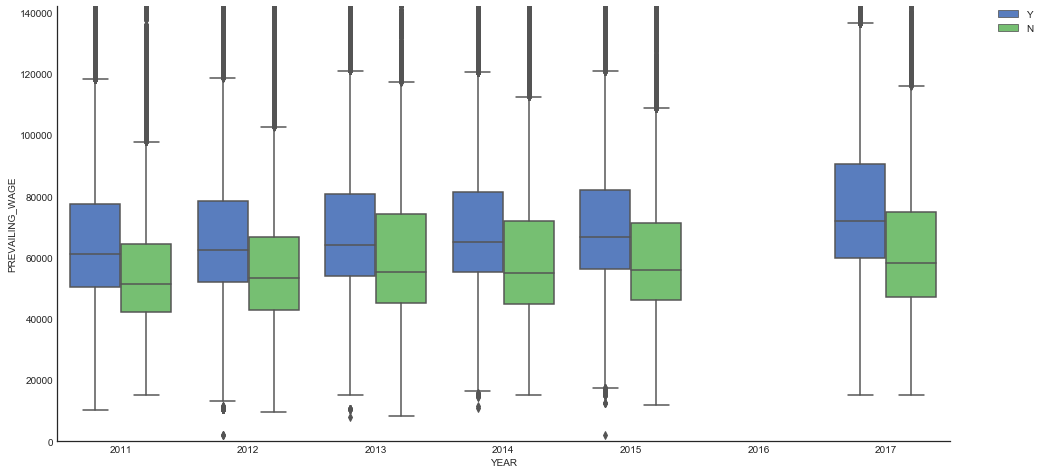

In [47]:
# create the matplotlib Figure and Axes objects
ax_dims = (16, 8)
fig, ax = plt.subplots(figsize=ax_dims)
sns.despine()
# create boxplot
sns.boxplot(x="YEAR", y="PREVAILING_WAGE", hue = "FULL_TIME_POSITION",
                    data=h1b_data, palette="muted").set_ylim([0, 142000]);
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Firstly, 2016 has missing data in the full time position column. How much data is missing overall in this field? 

In [48]:
# return percent missing data of col

def percent_missing(df, column):
    miss = df[column].isnull().sum()
    complete = len(df.index)
    return 100*(miss/complete)

In [49]:
percent_missing(h1b_data, 'FULL_TIME_POSITION')

17.871969143134589

Overall, just under 18% of the records in this data set have missing data in this column. This is an issue because knowing whether or not the is full-time is likely a significant predictor of approval. Also, because such a large number of records contain missing data in this field, it is not wise to simply throw these incomplete data away. 

One way to go about filling in such categorical data is to first refer back to the summary statistics of prevailing wages grouped by full-time position values. Looking at the 75 percentile in particular for cut-offs. 

In [50]:
# 75th percentile 
h1b_data.groupby('FULL_TIME_POSITION')['PREVAILING_WAGE'].quantile(.75)

FULL_TIME_POSITION
N   70324.80
Y   82659.00
Name: PREVAILING_WAGE, dtype: float64

In [51]:
# 25th percentile 
h1b_data.groupby('FULL_TIME_POSITION')['PREVAILING_WAGE'].quantile(.25)

FULL_TIME_POSITION
N   44616.00
Y   55016.00
Name: PREVAILING_WAGE, dtype: float64

Based on the 75th percentile, \$7000 will be used to separate full-time from non-full time jobs. This method is far from perfect and will strongly bias the distributions. Full-time wage distribution will be most impacted as it will have a very high floor effect which pulls the distribution up. 

In [52]:
# use imbedded np.where calls to fill missing vals (ifelse in R)
h1b_data['FULL_TIME_POSITION'] = np.where(h1b_data['FULL_TIME_POSITION'].isnull() == True, 
                                          np.where(h1b_data['PREVAILING_WAGE'] > 70000, 'Y', 'N'), 
                                          h1b_data['FULL_TIME_POSITION'])

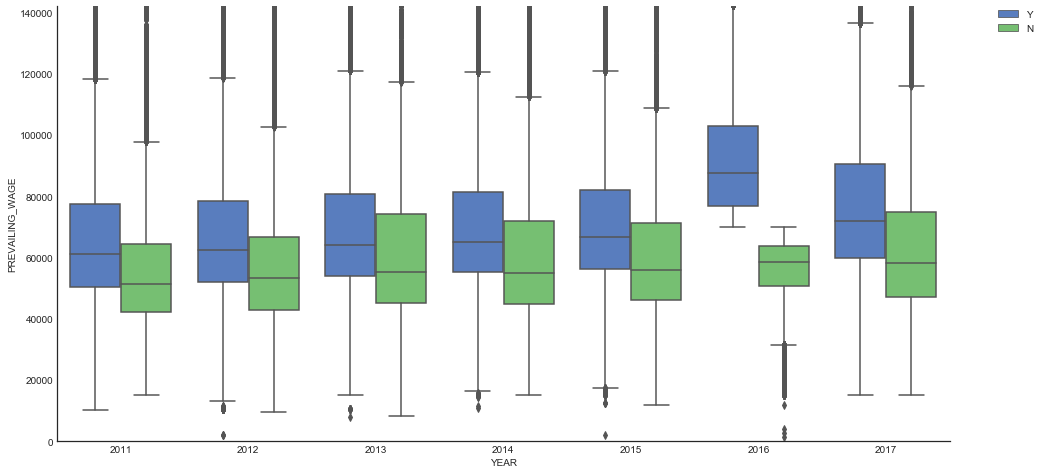

In [53]:
# create the matplotlib Figure and Axes objects
ax_dims = (16, 8)
fig, ax = plt.subplots(figsize=ax_dims)
sns.despine()
# create boxplot
sns.boxplot(x="YEAR", y="PREVAILING_WAGE", hue = "FULL_TIME_POSITION",
                    data=h1b_data, palette="muted").set_ylim([0, 142000]);
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

To get a sense of how much this process of replacing missing data biased the distributions of prevailing wages split by full time position, it is important to look at the overlap between the 2016 box plots and those of the other years. Looking at the 2016 prevailing wage distribution for full-time positions (Blue), we can see that the 50th percentile (median) lies above the 75th of the wage distributions of all other years, excluding 2017. Although the distributions overlap, I believe this is a problem which is not easily solved here. Any solution would introduce equivalent bias in the non-full-time distribution. 

### Location Transformations

This section will deal with making multiple location-based changes, beginning with cities from states.

Here are a list of the cities to inspect:

In [54]:
h1b_data['WORKSITE_CITY'].unique().tolist()

['EASTHAMPTON',
 'NEW YORK',
 'HOUSTON',
 'THE WOODLANDS',
 'BOSTON',
 'BEAVERTON',
 'SALISBURY',
 'MERRIMACK',
 'FORT MYERS',
 'SAN DIEGO',
 'NEWARK',
 'VISTA',
 'FREDERICK',
 'SEATTLE',
 'BROOKLYN',
 'SANTA CLARA',
 'NEW ALBANY',
 'WESTON',
 'HONOLULU',
 'HARTLAND',
 'SAN ANTONIO',
 'MALVERN',
 'WATERTOWN',
 'ANDREWS',
 'COLLIERVILLE',
 'WASHINGTON',
 'NEWPORT BEACH',
 'RICHMOND',
 'MIAMI',
 'AUSTIN',
 'SUNNYVALE',
 nan,
 'NORTHWOOD',
 'RIVERWOODS',
 'HOPEWELL',
 'WEST CHESTER',
 'JACKSONVILLE',
 'CARLSBAD',
 'FEDERAL WAY',
 'DURHAM',
 'CINCINNATI',
 'PUEBLO',
 'EAST WINDSOR',
 'MILFORD',
 'SAN RAFAEL',
 'JACKSON',
 'PETERSBURG',
 'TYLER',
 'CAMBRIDGE',
 'WINSTEAD',
 'GREENSBORO',
 'BERKELEY HEIGHTS',
 'CHAMBERSBURG',
 'WESTMONT',
 'CARSON CITY',
 'MIAMI BEACH',
 'SPRINGFIELD',
 'CLARKSBURG',
 'WEST DESMOINES',
 'COLORADO SPRINGS',
 'BEDFORD',
 'DULUTH',
 'LOS ANGELES',
 'MEMPHIS',
 'NEW ORLEANS',
 'LEWISPORT',
 'MARSHALL',
 'AUBURN HILLS',
 'PHOENIX',
 'SAN JOSE',
 'BOCA RATON',
 'O

In [55]:
# number of unique cities (including nan)
len(h1b_data['WORKSITE_CITY'].unique().tolist())

19785

Some of these records have issues with worksite values. The first issue is that some contain commas which separate the city from the state. This is not necessary as a column containing the state information already exists.  

Here is a subset of the data which contains a comma in the WORKSITE_CITY column:

In [56]:
# subset with comma
h1b_data[h1b_data['WORKSITE_CITY'].str.contains(",", na= False)]

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE_CITY,WORKSITE_STATE,YEAR
229,I-200-09238-727580,CERTIFIED,ISTREAM SOLUTIONS INC.,Computer Systems Analysts,15-1051.00,PROGRAMMER ANALYST,Y,62067.00,"WASHINGTON, DC",DC,2011
436,I-200-09342-235537,WITHDRAWN,ISTREAM SOLUTIONS INC.,Computer Systems Analysts,15-1051.00,PROGRAMMER ANALYST,Y,62067.00,"WASHINGTON, DC",DC,2011
691,I-200-10064-534888,CERTIFIED,THE PRINCIPAL CONSULTING INC.,Computer Systems Analysts,15-1051.00,PROGRAMMER ANALYST,Y,42786.00,"HICKORY, NC",NC,2011
1904,I-200-10243-622106,CERTIFIED,SUBURBAN HOSPITAL,"Medical Scientists, Except Epidemiologists",19-1042,RESEARCH FELLOW,Y,60362.00,"BETHESDA, MD",MD,2011
2482,I-200-10265-003788,CERTIFIED,CQUENT SYSTEMS INC,Computer Programmers,15-1021.00,PROGRAMMER ANALYST,Y,50357.00,"ARLINGTON HEIGHTS,",IL,2011
2525,I-200-10266-000003,CERTIFIED,EXECUTEK SYSTEMS LLC,Computer Systems Analysts,15-1051.00,ASSOCIATE PARTNER AND SYSTEMS ENGINEER,Y,62067.00,"WASHINGTON, DC",MD,2011
2968,I-200-10273-492661,CERTIFIED,"UNIVERSITY OF PUERTO RICO, RIO PIEDRAS CAMPUS",Zoologists and Wildlife Biologists,19-1023.00,ASSISTANT RESEARCHER IN BIOLOGY POST DOC,Y,26686.00,"RIO PIEDRAS, SAN JUAN",PR,2011
5558,I-200-10277-287795,CERTIFIED,COMPEST SOLUTIONS INC.,Computer Programmers,15-1021.00,PROGRAMMER / PERFORMANCE ANALYST,Y,65770.00,"CHARLOTTE,",NC,2011
5646,I-200-10277-019771,CERTIFIED,"MARLABS, INC",Computer Programmers,15-1021.00,PROGRAMMER/ANALYST,Y,68682.00,"LOS ANGELES,",CA,2011
5828,I-200-10277-170857,CERTIFIED,"MARLABS, INC",Computer Programmers,15-1021.00,PROGRAMMER/ANALYST,Y,58490.00,"HOUSTON,",TX,2011


We can see that 10020 rows have this issue. 

I can split the column by comma and select the first position before the comma (extract the city) as such:

In [57]:
# extract city
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].str.split(",", expand = True)[0]

Now to confirm the column is fixed and contains no commas:

In [58]:
# subset with comma
sum(h1b_data['WORKSITE_CITY'].str.contains(",", na= False))

0

Perfect.

We can also see that a number of records in this column (1947) contain numbers which I would not expect to find in these values:

In [59]:
sum(h1b_data['WORKSITE_CITY'].str.contains("[0-9]", na= False))

1942

In [60]:
# subet base on number
h1b_data[h1b_data['WORKSITE_CITY'].str.contains("[0-9]", na= False)]

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE_CITY,WORKSITE_STATE,YEAR
1721,I-200-10230-588749,CERTIFIED,"INNOWAVE TECHNOLOGY, LLC","Computer Software Engineers, Applications",15-1031.00,SENIOR PRINCIPAL SOFTWARE CONSULTANT,Y,113651.00,SUITE 230,CA,2011
1781,I-200-10236-666127,DENIED,SOFTPATH SYSTEMS INC,Computer Programmers,15-1021.00,COMPUTER PROGRAMMER,Y,65582.40,SUITE # 903,NY,2011
2176,I-200-10258-366766,DENIED,"MY-HANH TRIEU, O.D. INC.",Optometrists,29-1041.00,OPTOMETRIST,N,62545.60,6015 WILSON BLVD.,VA,2011
4379,I-200-10274-143262,CERTIFIED,UNIVERSAL SOFTWARE CORPORATION,Database Administrators,15-1061.00,DATABASE ADMINISTRATOR,Y,56701.00,3403 YERBA BUENA ROAD,CA,2011
5554,I-200-10277-676223,CERTIFIED,"OLD MUTUAL BERMUDA BUSINESS SERVICES, INC.",Financial Managers,11-3031.00,ASSISTANT VICE PRESIDENT - HEDGING,Y,125882.00,32ND FLOOR,NY,2011
6926,I-200-10278-307138,CERTIFIED,"JACKSON THERAPY PARTNERS, LLC",Physical Therapists,29-1123.00,PHYSICAL THERAPIST,Y,62233.60,3400 W WASHINGTON STREET,IL,2011
9882,I-200-10281-495963,CERTIFIED,"HEALTH CHOICE HOME CARE SERVICE, LLC",Physical Therapists,29-1123.00,PHYSICAL THERAPIST,Y,52437.00,#47644,MI,2011
11287,I-200-10284-833059,CERTIFIED,"NEXAGE TECHNOLOGIES, USA, INC","Computer Software Engineers, Applications",15-1031.00,SOFTWARE ENGINEER,Y,56326.40,SUITE 104,NJ,2011
13933,I-200-10286-346421,CERTIFIED,WOW GLOBAL CORPORATION LLC,Computer Programmers,15-1021.00,PROGRAMMER/ANALYST,Y,59384.00,3114 GRANDVIEW BLVD,WI,2011
15279,I-200-10287-772067,CERTIFIED,"TRULIA, INC.","Computer Software Engineers, Systems Software",15-1032.00,DATA WAREHOUSE ENGINEER,Y,97178.00,SUITE 310,CA,2011


Because the data was given incorrectly, I will drop these rows from the data set and check it was successful.

In [61]:
# drop these rows
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].astype(str)
h1b_data = h1b_data[~h1b_data.WORKSITE_CITY.str.contains("[0-9]")]

In [62]:
sum(h1b_data['WORKSITE_CITY'].str.contains("[0-9]", na= False))

0

Another strange artifact is that some records (199) begin with a tag ('&NBSP;' before their actual value in the city column. 

In [63]:
sum(h1b_data['WORKSITE_CITY'].str.contains("&NBSP;", na= False))

199

In [64]:
# replace string ""
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace("&NBSP;", "", regex = True)

In [65]:
sum(h1b_data['WORKSITE_CITY'].str.contains("&NBSP;", na= False))

0

A final problem I have seen before is periods in place of missing data or accidentally dropped into the data set. It is not okay to replace them blindly in this case because some cities contain periods (eg "St. Louis). This is also important for these data because I believe data will be entered such that state is replicated with a period following the city (eg: St. Louis. MO). There are also tons of problems which are related to periods in databases which I want to check for - such as individuals putting their street name in the cities column (eg: Apple St.). 

In [126]:
sum(h1b_data['WORKSITE_CITY'].str.contains("\.", na= False))

21549

In [124]:
# make subset of cities with periods
periods_df = h1b_data[h1b_data['WORKSITE_CITY'].str.contains("\.", na = False)]

In [125]:
periods_df['WORKSITE_CITY'].unique().tolist()

['ST. LOUIS',
 'ST. LOUIS PARK',
 'ST. THOMAS',
 'ST. CROIX',
 'MT. VERNON',
 'ST. PETERSBURG',
 'ST. PAUL',
 'ST. JOSEPH',
 'ST. AUGUSTINE',
 "ST. MARY'S CITY",
 'ST. CHARLES',
 'FT. DODGE',
 'PORT ST. LUCIE',
 'FT. BELVOIR',
 'MT. LAUREL',
 'WASHINGTON D.C',
 'S. PLAINFIELD',
 'MS. STATE',
 'NORTH ST. PAUL',
 'MISS. STATE',
 'MOON TWP.',
 'FT. LEE',
 'WASHINGTON D.C.',
 'ST. ALBANS',
 'MT. RANIER',
 'FT. LAUDERDALE',
 'N. MIAMI',
 'ST. CLOUD',
 'ST. PORTLAND',
 'ST. JAMES',
 'ST. GENEVIEVE',
 'W.COLUMBIA',
 'ST.LOUIS',
 'FT. WAYNE',
 'FT. WORTH',
 'ST. CLAIRSVILLE',
 'MT. CLEMENS',
 'WAHINGTON D.C.',
 'FT. PIERCE',
 'FT. MYERS',
 'STE. GENEVIEVE',
 'ST. LUCIE',
 'ST. CLAIR SHORES',
 'FT. COLLINS',
 'CT. FRANKLIN',
 'ST. GEORGE',
 'ST. PETERS',
 'MT. PLEASANT',
 'MT. ZION',
 'ST.  LOUIS',
 'INVER GROVE HTS.',
 'ST. SIMONS',
 'S. MINNEAPOLIS',
 'ST.PAUL',
 'NORTH ST. PETERSBURG',
 'WARRENSVILLE HTS.',
 'FT. CARSON',
 'E. LANSING',
 'LAKE ST. LOUIS',
 'S.W.',
 'ST. PETE BEACH',
 'ROWLAN

**List of problems found:** 
* WAHINGTON D.C.
* WASHINGTON. D.C.
* WASHIONTON D.C.
* WASHINGRTON D.C.
* NW WASHINGTON D.C.
* WASHINTON D.C'
* D.C.
* WASHINGTON.
* CUYAHOGA HEIGHTS.
* SAN DIEGO.
* MT.PLEASANT
* ALLENTOWN. PA.
* '.'
* . PORT WASHINGTON
* MINNEAPOLIS/ST. PAUL
* S. ST. PUAL
* ST.LOUIS. MO
* ST.LOIUS
* ST. LOUSIS
* ST. LOUISE
* ST.LOUIS CITY
* VBROWN@DUANEMORRIS.COM
* ST.PETERSBIRG
* MARINE ON ST. CROIX
* DR.EAGAN
* L.I.C.
* DR. LANGHORNE
* COLUMBUS OH.
* DR.BEAVERTON
* BLDG.
* JONESD@JACKSONLEWIS.COM
* PHILADELPHIA PA.
* CUSTER AVE.
* LIVONIA.
* . SUNNYVALE
* JOHN S. TOLL PHYSICS BUILDING
* METUCHEN.
* DR. URBANDALE
* MS. STAE
* BRONX.NEW YORK
* N.WASHINGTON AVE
* FOSTER PARK DR.
* MT. PROSPECT DR.
* VALATIE.
* COMMACK. NY
* DR. RICHARDSON
* H.
* FT. LAUDERDALEFT. LAUDERDALE
* FT. LAUDERSALE
* ST. JOHNSBURTY
* RENCHVILLE RD.
* DALLAS FT. WORTH
* DR. PAWTUCKET
* ATLANTIC CITY INTL. AIRPORT
* SOUTHBOROUGH.
* SR. CHARLES
* EAGAN.
* ST.. PETERSBURG
* CLEVELAND (CUYAHOGA HTS.)
* TAMPA.
* SUB BASE ST. THOMAS

I will start fixing these issues to allow for easier geo-encoding and geo work in the future. I will make lists of common errors which can be replaced by the same city and then use a hash table to make all the replacements in one call.  

I will begin with swooping replacements which can be replaced by one term. 

In [332]:
# replaced with WASHINGTON
wash_replace = ["WAHINGTON D.C.", "WASHINGTON. D.C.", "WASHIONTON D.C.", "WASHINGRTON D.C.", 
                "NW WASHINGTON D.C.", "WASHINTON D.C", "D.C.", "WASHINGTON.", "WASHINGTON D.C", "WASHINGTON D. C.", 
                "WASHINGTON D.C.", "WASHINTGON D.C.", "N.WASHINGTON AVE"]
# replaced with St. Louis
stLouis_replace = ["ST.LOUIS. MO", "ST.LOIUS", "ST. LOUSIS", "ST. LOUISE",  "ST.LOUIS CITY"]

# replaced with ""
trash_replace = [". ", "VBROWN@DUANEMORRIS.COM", "DR.EAGAN", "L.I.C.", "DR. LANGHORNE", "DR.BEAVERTON", 
                 "BLDG.", "JONESD@JACKSONLEWIS.COM", "CUSTER AVE.", "JOHN S. TOLL PHYSICS BUILDING", 
                 "DR. URBANDALE", "MS. STAE", "FOSTER PARK DR", "MT. PROSPECT DR.", "DR. RICHARDSON",
                 "H.", "RENCHVILLE RD.", "DR. PAWTUCKET"]

Now for the other mistakes:

In [342]:
# change lists to tuples
period_hash =  { "CUYAHOGA HEIGHTS." : "CUYAHOGA HEIGHTS",  "SAN DIEGO." : "SAN DIEGO", 
                 "MT.PLEASANT" : "MT. PLEASANT", "ALLENTOWN. PA." : "ALLENTOWN", 
                 ". PORT WASHINGTON" : "PORT WASHINGTON", "MINNEAPOLIS/ST. PAUL" : "MINNEAPOLIS", 
                 "S. ST. PUAL" : "ST. PAUL", "METUCHEN." : "METUCHEN", "BRONX.NEW YORK": "BRONX", 
                 "VALATIE." : "VALATIE", "COMMACK. NY" : "COMMACK", "FT. LAUDERDALEFT. LAUDERDALE" : "FT. LAUDERDALEFT", 
                 "ST. JOHNSBURTY" : "ST. JOHNSBURY", "DALLAS FT. WORTH" : "DALLAS", 
                 "ATLANTIC CITY INTL. AIRPORT" : "ATLANTIC CITY", "SOUTHBOROUGH." : "SOUTHBOROUGH", 
                 "EAGAN." : "EAGAN", "ST.. PETERSBURG" : "ST. PETERSBURG", "CLEVELAND (CUYAHOGA HTS.)" : "CLEVELAND", 
                 "TAMPA." : "TAMPA", "SUB BASE ST. THOMAS" : "ST. THOMAS" }

Next, I will make a dictionary of key value pairs from the lists made above:

In [333]:
# generate key value pairs:
wash = dict.fromkeys(wash_replace, 'WASHINGTON')
louis = dict.fromkeys(stLouis_replace, 'ST. LOUIS')
trash = dict.fromkeys(trash_replace, '')

Now, I will apply these key values pairs to make the appropriate replacements.

In [334]:
# apply replacements for each list:
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(wash)
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(louis)
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(trash)

Finally, I will apply the hash table to replace unique errors which cannot be replaced with a single term.

In [343]:
# apply hash replacement:
h1b_data = h1b_data.replace({"WORKSITE_STATE": period_hash})

Finally, there are a few records which cannot be replaced using a hash table (for a seemingly unknown reason). I will replace manually. 

In [355]:
# manual replacements:
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(". PORT WASHINGTON", "PORT WASHINGTON")
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(". SUNNYVALE", "SUNNYVALE")
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace(":LAS VEGAS" , "LAS VEGAS" )
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace('"FRAMINGHAM' , 'FRAMINGHAM' )
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace('"NEW YORK' , 'NEW YORK' )
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace("'CHARLESTON" , "CHARLESTON" )
h1b_data['WORKSITE_CITY'] = h1b_data['WORKSITE_CITY'].replace("ÒAKBROOK TERRACE" , "OAKBROOK TERRACE" )

Errors solved. 

Next, I need to change the state abbreviations to their complete names to latter merge then with cities. Changing the abbreviated states into their full forms can be done using a Python dictionary as a hashmap. 

In [325]:
# hash table for states
state_hash = { "AK" : "alaska",  "AL" : "alabama", "AR" : "arkansas", "AZ" : "arizona", 
               "CA" : "california", "CO" : "colorado", "CT" : "connecticut", "DC" : "district of columbia",
               "DE" : "delaware", "FL" : "florida", "GA" : "georgia", "HI" : "hawaii",
               "IA" : "iowa", "ID" : "idaho", "IL" : "illinois", "IN" : "indiana",
               "KS" : "kansas", "KY" : "kentucky", "LA" : "louisiana", "MA" : "massachusetts",
               "MD" : "maryland", "ME" : "maine", "MI" : "michigan", "MN" : "minnesota",
               "MO" : "missouri", "MS" : "mississippi", "MT" : "montana", 
               "NC" : "north carolina", "ND" : "north dakota", "NE" : "nebraska", "NH" : "new hampshire",
               "NJ" : "new jersey", "NM" : "new mexico", "NV" : "nevada", "NY" : "new york",
               "OH" : "ohio", "OK" : "oklahoma", "OR" : "oregon", "PA" : "pennsylvania",
               "PR" : "puerto rico", "RI" : "rhode island", "SC" : "south carolina", "SD" : "south dakota",
               "TN" : "tennessee", "TX" : "texas", "UT" : "utah", "VA" : "virginia", 
               "VT" : "vermont", "WA" : "washington", "WI" : "wisconsin", "WV" : "west virginia", 
               "WY" : "wyoming" }

Replace the abbreviations:

In [326]:
# replace the values 
h1b_data = h1b_data.replace({"WORKSITE_STATE": state_hash})

In [327]:
h1b_data['WORKSITE_STATE'].head(6)

0    massachusetts
1         new york
2            texas
3            texas
4    massachusetts
5           oregon
Name: WORKSITE_STATE, dtype: object

The states have successfully being replaced with their full names. Now I can merge cities and states into one column:

In [350]:
# merge city and state
def site_merge(city, state):
    city = str(city)
    state = str(state) 
    if city == "" and state == "":
        return ""
    elif city == "":
        return f"{state.upper()}"
    elif state == "":
        return f"{city}"
    else:
        return f"{city},  {state.upper()}"

The really tricky part here is that I do not want to merge records which have NaN values in either column or else I will have records which will look like ",NEW YORK" or "NEW YORK," after applying the merging function. This means I want to apply the function only to non-null records, which I have taken care of in the function above. 

In [360]:
# make new col by merge
h1b_data['WORKSITE'] = h1b_data[['WORKSITE_CITY','WORKSITE_STATE']].apply(
   lambda x: site_merge(*x), axis = 1
)

Now that the city and states have been merged into one new column named 'WORKSITE', let's check the merge was successful:

In [361]:
h1b_data['WORKSITE'].head(6)

0    EASTHAMPTON,  MASSACHUSETTS
1            NEW YORK,  NEW YORK
2                HOUSTON,  TEXAS
3          THE WOODLANDS,  TEXAS
4         BOSTON,  MASSACHUSETTS
5             BEAVERTON,  OREGON
Name: WORKSITE, dtype: object

Looks great - although I am sure it is not perfect. I could spend a week just fixing these types of errors.  I know I have now at least taken care of some big and prevalent ones. 

After merging the city and state, the city column can be dropped:

In [364]:
# drop col
h1b_data = h1b_data.drop("WORKSITE_CITY", axis = 1)

Here's a look at some of the worksites after merging. Again, I could find many more errors and incorporate regular expressions to do so, but for now this is fine. 

In [365]:
# unique worksties:
h1b_data['WORKSITE'].unique().tolist()

['EASTHAMPTON,  MASSACHUSETTS',
 'NEW YORK,  NEW YORK',
 'HOUSTON,  TEXAS',
 'THE WOODLANDS,  TEXAS',
 'BOSTON,  MASSACHUSETTS',
 'BEAVERTON,  OREGON',
 'SALISBURY,  MARYLAND',
 'MERRIMACK,  NEW HAMPSHIRE',
 'FORT MYERS,  FLORIDA',
 'SAN DIEGO,  CALIFORNIA',
 'NEWARK,  CALIFORNIA',
 'VISTA,  CALIFORNIA',
 'FREDERICK,  MARYLAND',
 'SEATTLE,  WASHINGTON',
 'BROOKLYN,  NEW YORK',
 'SANTA CLARA,  CALIFORNIA',
 'NEW ALBANY,  OHIO',
 'WESTON,  FLORIDA',
 'HONOLULU,  HAWAII',
 'HARTLAND,  WISCONSIN',
 'SAN ANTONIO,  TEXAS',
 'MALVERN,  PENNSYLVANIA',
 'WATERTOWN,  NEW YORK',
 'ANDREWS,  TEXAS',
 'COLLIERVILLE,  TENNESSEE',
 'WASHINGTON,  DISTRICT OF COLUMBIA',
 'NEWPORT BEACH,  CALIFORNIA',
 'RICHMOND,  VIRGINIA',
 'MIAMI,  FLORIDA',
 'AUSTIN,  TEXAS',
 'SUNNYVALE,  CALIFORNIA',
 'nan,  NAN',
 'NORTHWOOD,  OHIO',
 'RIVERWOODS,  ILLINOIS',
 'HOPEWELL,  VIRGINIA',
 'WEST CHESTER,  OHIO',
 'JACKSONVILLE,  FLORIDA',
 'CARLSBAD,  CALIFORNIA',
 'FEDERAL WAY,  WASHINGTON',
 'DURHAM,  NORTH CAROLINA'

### Correcting misspellings

Now that some silly mistakes have been taken out, I can move on to correct honest misspelling of words.

This spell checker is taken from here: http://norvig.com/spell-correct.html. It works based on probabilities and a full explanation can be found on that web page. To obtain probabilities, a hash table of work sites and their corresponding counts is required.   

I will begin by getting counts of each worksite.

In [445]:
# aggregate counts grouped by worksite
counts = h1b_data.groupby('WORKSITE').agg('count')

I will put the aggregated counts, sorted in descending order, into a tidy data frame. This is very easy with dplyr and magrittr and not so nice with pandas.

In [447]:
# sort vals of firsrt col
counts = pd.DataFrame(counts['CASE_NUMBER'].sort_values(ascending=False))
counts['SITE_COUNTS'] = counts['CASE_NUMBER'] # rename
counts = counts.drop(['CASE_NUMBER'], axis = 1) # drop old cols


Here are the top 10 worksites represented in these data:

In [458]:
counts.head(10)

,SITE_COUNTS
WORKSITE,
"NEW YORK, NEW YORK",228262
"HOUSTON, TEXAS",96781
"SAN FRANCISCO, CALIFORNIA",78267
"CHICAGO, ILLINOIS",62966
"ATLANTA, GEORGIA",62841
"SAN JOSE, CALIFORNIA",60746
"SUNNYVALE, CALIFORNIA",43115
"DALLAS, TEXAS",39451
"BOSTON, MASSACHUSETTS",37984


Next, I'll make a hash table of the sites and their corresponding counts.

In [450]:
sites_hash = counts.to_dict()

Now to import the spell checker from the website linked at the start of this section:

In [438]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open("C:/Users/nicho/Desktop/big data course proj/H-1B data/big.txt").read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
#site_count <- function(site, site_hash) {
  
#  if(site_hash$has_key(site)) {
#    return(site_hash[[site]])
#  }
#  return(site)
#}

In [453]:
def site_count(site, site_hash):
    if(site in site_hash):
        return site_hash[[site]]
    return site

In [465]:
temp = counts.reset_index(drop=False)
site_counts = pd.DataFrame()
site_counts = pd.concat([site_counts, temp[['WORKSITE', 'SITE_COUNTS']]], axis=1)

In [468]:
sites = site_counts['WORKSITE']
sites_before = []
sites_after = []
count = 0

In [ ]:
for site in sites:
    #count of current worksite
    curr_count <- site_count(site, site_hash)
    
    if curr_count < 100: # threshold
        corrected = correction()

In [471]:
h1b_data.head()

,CASE_NUMBER,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,SOC_CODE,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE_STATE,YEAR,WORKSITE
0,I-200-09124-371007,CERTIFIED,WILLISTON NORTHAMPTON SCHOOL,"Teachers and Instructors, All Other*",25-3999,CHINESE TEACHER,Y,23350.00,massachusetts,2011,"EASTHAMPTON, MASSACHUSETTS"
1,I-200-09125-717448,CERTIFIED,"NYFIX, INC.","Computer Software Engineers, Applications",15-1031.00,PROJECT MANAGER,Y,101088.00,new york,2011,"NEW YORK, NEW YORK"
2,I-200-09126-530125,CERTIFIED-WITHDRAWN,TGS-NOPEC GEOPHYSICAL COMPANY,"Computer Software Engineers, Applications",15-1031.00,PRINCIPAL TRAINER / DEVELOPMENT ANALYST,Y,77480.00,texas,2011,"HOUSTON, TEXAS"
3,I-200-09127-370154,CERTIFIED,"AFREN USA, INC.",Engineering Managers,11-9041.00,DRILLING MANAGER,Y,165506.00,texas,2011,"THE WOODLANDS, TEXAS"
4,I-200-09127-334015,CERTIFIED,"BA-INSIGHT, LLC",Computer Support Specialists,15-1041.00,TECHNICAL SUPPORT ENGINEER,Y,62358.00,massachusetts,2011,"BOSTON, MASSACHUSETTS"


In [472]:
# write to csv
h1b_data.to_csv("./Desktop/big data course proj/H-1B data/pregeo_encoding.csv", index = False)